Information based approach

refer to some literature
- kriegskorte 


In [224]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from sklearn.preprocessing import StandardScaler

In [225]:
# load data from one participant
data_path = Path(Path.cwd()).parents[1] / "data" / "preprocessed"
epochs = mne.read_epochs(data_path / "Group1-epo.fif", verbose=False, preload=True)

## Decoding one subject at a time

In [226]:
epochs.pick_types(eeg=True)

# get all the word trials from the first participant
words = epochs["Word"].get_data()

# get the button press trials from the first participant (only correct)
buttons = epochs["Correct"].get_data()

In [227]:
y = [0] * len(words) + [1] * len(buttons)

# concatenate the data along the trials axis
X = np.concatenate([words, buttons], axis=0)


### Lets start by only focusing on one timepoint

In [228]:
# get data from timesample 100 
X_t100 = X[:, :, 100]

print(X_t100.shape)

In [230]:
def cross_val_splits(X, y, n_splits=5, shuffle=True, balance=True, stratify=True):
    """
    Function to create cross validation splits
    
    Parameters
    ----------
    X : np.ndarray
        The data to split of shape (n_trials, n_channels) or (n_trials, n_channels, n_timesamples)

    y : np.ndarray
        The labels of shape (n_trials,) with 0 indicating the first class and 1 the second class

    n_splits : int
        The number of splits to create
    
    shuffle : bool
        Whether to shuffle the data before splitting
    
    balance : bool
        Whether to balance the data before splitting (i.e. have the same number of trials for each class in each split)

    stratify : bool
        Whether to stratify the data before splitting (i.e. have the same class distribution in each split)
    
    Returns
    -------
    Xs : list
        A list of length n_splits containing the data splits
    
    ys : list
        A list of length n_splits containing the label splits
    """

    if balance:
        # Get the indices of the trials for each class
        idx_0 = np.where(y == 0)[0]
        idx_1 = np.where(y == 1)[0]

        # Get the minimum number of trials for each class
        min_trials = min(len(idx_0), len(idx_1))

        # Randomly sample the indices and concatenate them
        idx = np.concatenate([np.random.choice(idx_0, min_trials, replace=False),
                              np.random.choice(idx_1, min_trials, replace=False)])

        # Get the data and labels for the balanced data
        X, y = X[idx], y[idx]

    idx = np.arange(len(X))

    if shuffle:
        np.random.shuffle(idx)

    if stratify:
        # Get the indices of the trials for each class
        idx_0 = np.where(y == 0)[0]
        idx_1 = np.where(y == 1)[0]

        # Concatenate the indices for each class
        idx_splits = [np.concatenate([np.array_split(idx_class, n_splits)[i] for idx_class in [idx_0, idx_1]]) for i in range(n_splits)]

        # Randomly shuffle the indices for each split
        idx_splits = [np.random.permutation(split) for split in idx_splits]

        # Concatenate the indices
        idx = np.concatenate(idx_splits)

    # split the data into n_splits
    splits = np.array_split(idx, n_splits)

    Xs = [X[split] for split in splits]
    ys = [y[split] for split in splits]

    return Xs, ys


In [231]:
n_splits = 5

# create cross validation splits
Xs, ys = cross_val_splits(
    X_t100, 
    np.array(y), 
    n_splits = n_splits,
    shuffle = True,
    balance = True,
    stratify = True
)

# make the classifier object
clf = lda()


accuracies = np.array([])

# loop over the splits
for i in range(n_splits):
    # get the train and test data
    X_train = np.concatenate([Xs[j] for j in range(n_splits) if j != i], axis=0)
    X_test = Xs[i]

    y_train = np.concatenate([ys[j] for j in range(n_splits) if j != i], axis=0)
    y_test = ys[i]

    # fit the classifier
    clf.fit(X_train, y_train)

    # get the accuracy
    accuracy = clf.score(X_test, y_test)

    # append the accuracy to the list
    accuracies = np.append(accuracies, accuracy)

print(accuracies)
print(f"mean accuracy: {np.mean(accuracies)}")


[0.88888889 0.88888889 0.94444444 0.72222222 0.88888889]
mean accuracy: 0.8666666666666668


## Now lets look at all timepoints

In [232]:
# create cross validation splits
Xs, ys = cross_val_splits(
    X, 
    np.array(y), 
    n_splits = n_splits,
    shuffle = True,
    balance = True,
    stratify = True
)

In [233]:
# make a shape (n_splits, n_timesamples) array to store the accuracies
accuracies = np.zeros((n_splits, X.shape[2]))

# make a shape to store the beta coefficients
betas = np.zeros((n_splits, X.shape[1], X.shape[2]))

scaler = StandardScaler()

# loop over the splits
for i in range(n_splits):
    # get the train and test data
    X_train = np.concatenate([Xs[j] for j in range(n_splits) if j != i], axis=0)
    X_test = Xs[i]

    y_train = np.concatenate([ys[j] for j in range(n_splits) if j != i], axis=0)
    y_test = ys[i]

    # loop over the timesamples
    for t in range(X_train.shape[2]):
        
        # scale the data
        X_train_scaled = scaler.fit_transform(X_train[:, :, t])
        X_test_scaled = scaler.transform(X_test[:, :, t])

        # fit the classifier
        clf.fit(X_train_scaled, y_train)

        # get the accuracy
        accuracy = clf.score(X_test_scaled, y_test)

        # save the beta coefficients
        betas[i, :, t] = clf.coef_

        # save the accuracy
        accuracies[i, t] = accuracy

print(f"mean accuracy: {np.mean(accuracies)}")

mean accuracy: 0.7141587301587301


Text(0, 0.5, 'Accuracy')

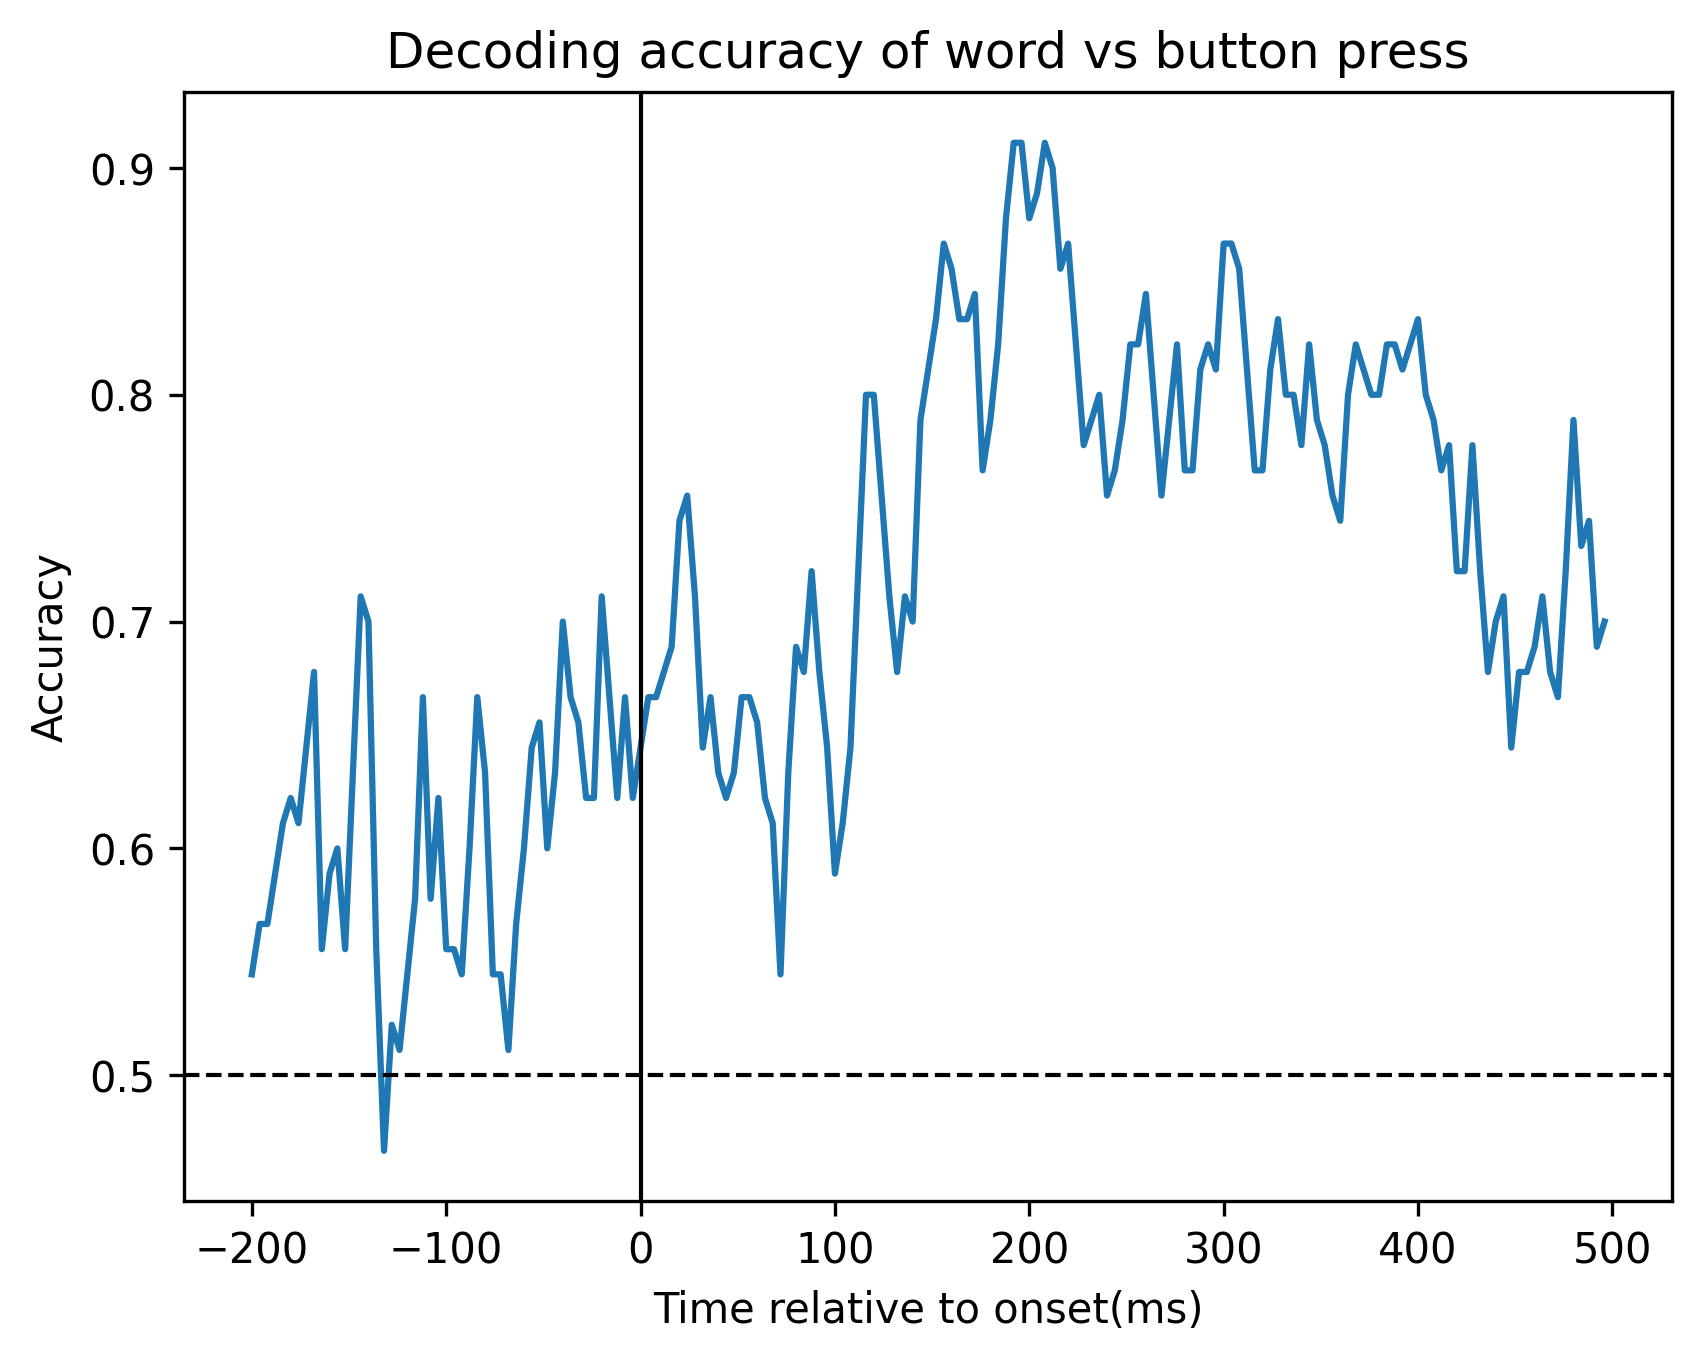

In [234]:
# plot the accuracy over time
fig, ax = plt.subplots(dpi = 300)

# take the mean over the splits
accuracies_avg = np.mean(accuracies, axis=0)

# times instead of timesamples (250 hz, from -200 ms to 500 ms)
times = np.arange(-200, 500, 4)

# plot the accuracies
ax.plot(times, accuracies_avg)

# plot a horizontal line at chance level
ax.axhline(0.5, color="black", linestyle="--", linewidth=1)

# plot a vertical line at 0 ms indicating onset
ax.axvline(0, color="black", linestyle="solid", linewidth=1)

ax.set_title("Decoding accuracy of word vs button press")

ax.set_xlabel("Time relative to onset(ms)")
ax.set_ylabel("Accuracy")

#### Plot betas for timepoints on a topoplot

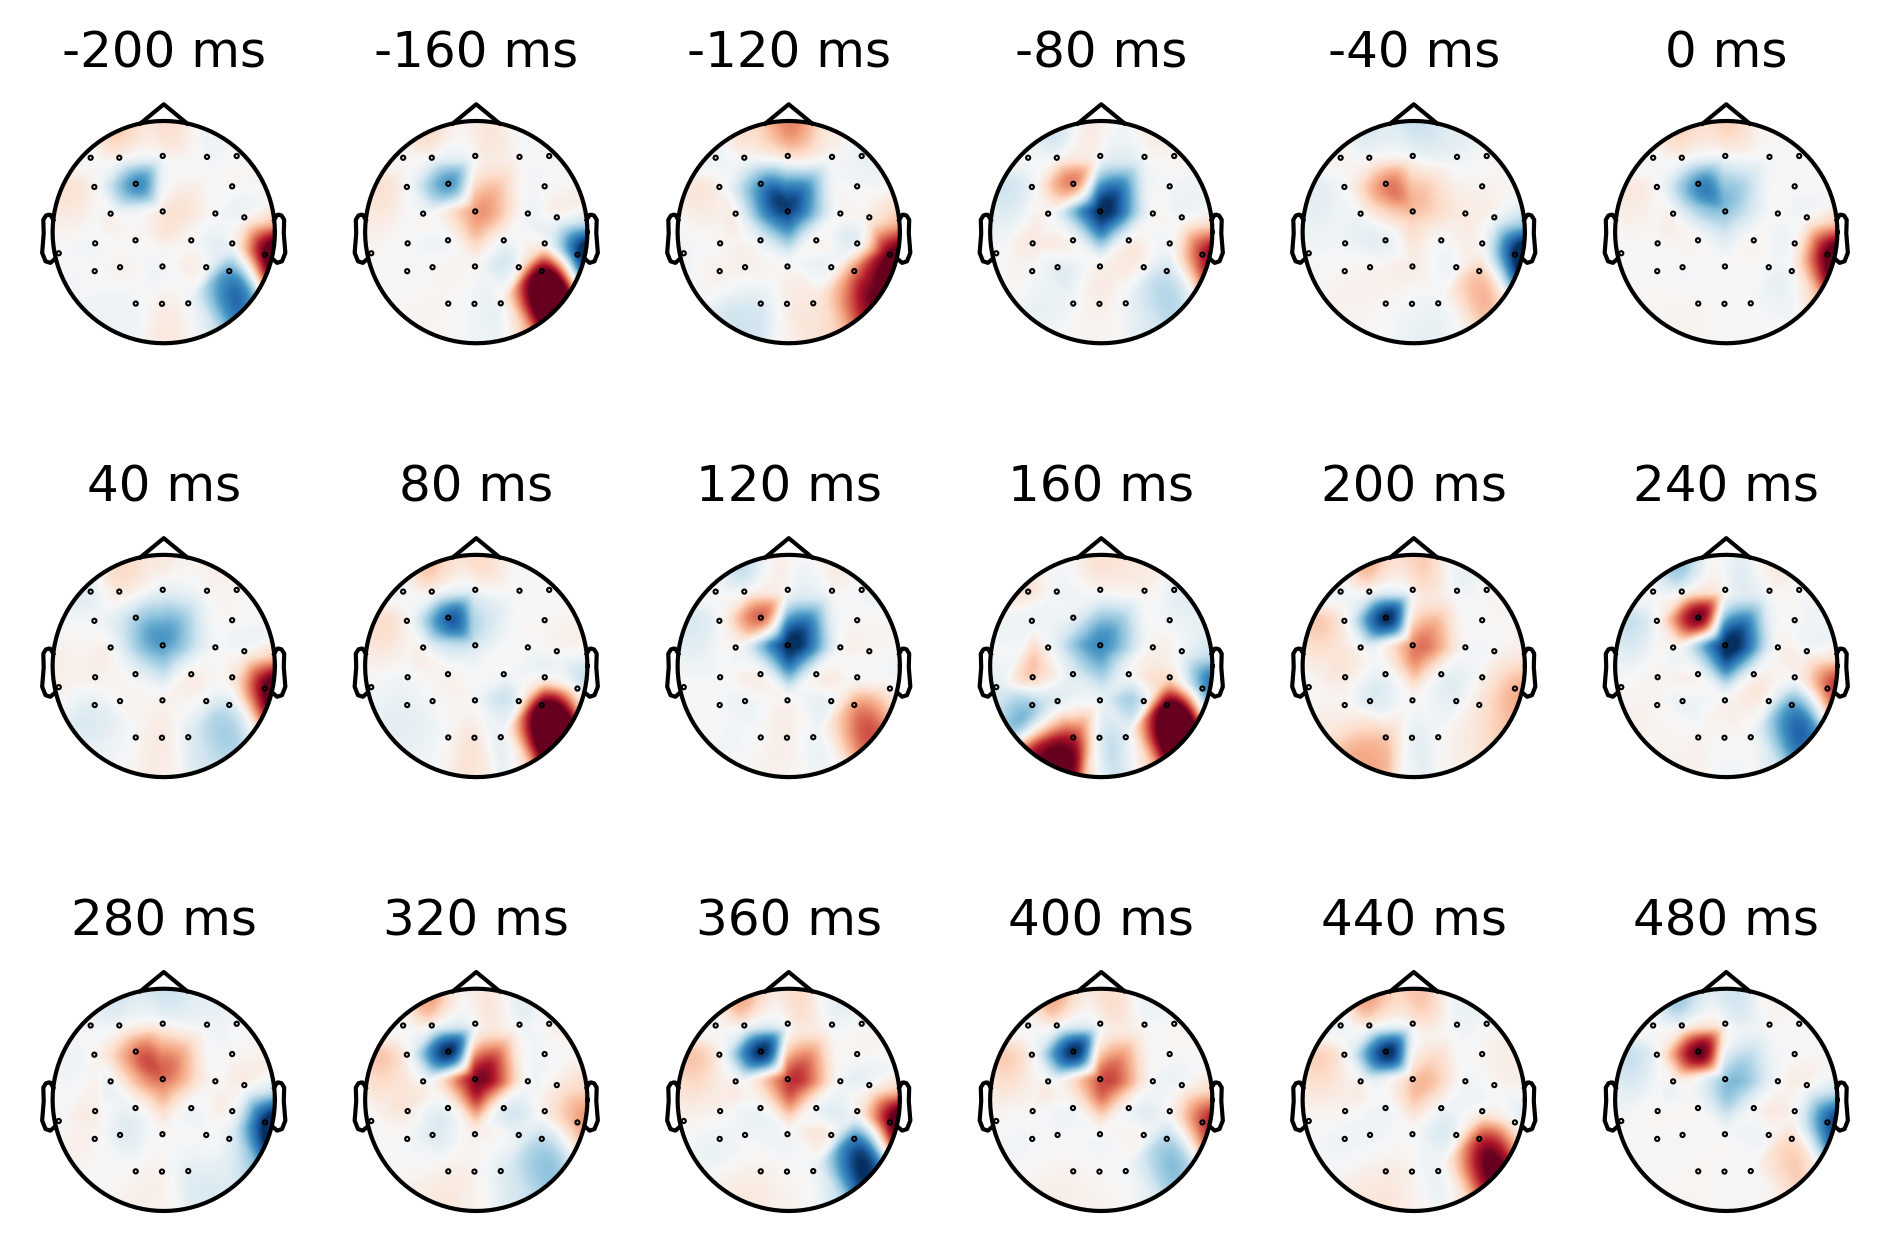

In [235]:
# choosing some times to plot
times_to_plot = np.arange(0, len(times), 10)

fig, axes = plt.subplots(3, len(times_to_plot)//3,  dpi=300, sharex=True, sharey=True)

for i, ax in enumerate(axes.flat):
    mne.viz.plot_topomap(betas[:, :, times_to_plot[i]].mean(axis=0), epochs.info, axes=ax, show=False, contours=0)
    ax.set_title(f"{times[times_to_plot[i]]} ms")

# plot 

fig.tight_layout()